# Hands-on Image Processing with Python
## Chapter 11: Deep Learning - Object Detection, Segmentation, Transfer Learning and Neural Style Transfer

## Author: Sandipan Dey

## Semantic Segmentation with DeepLab V3+

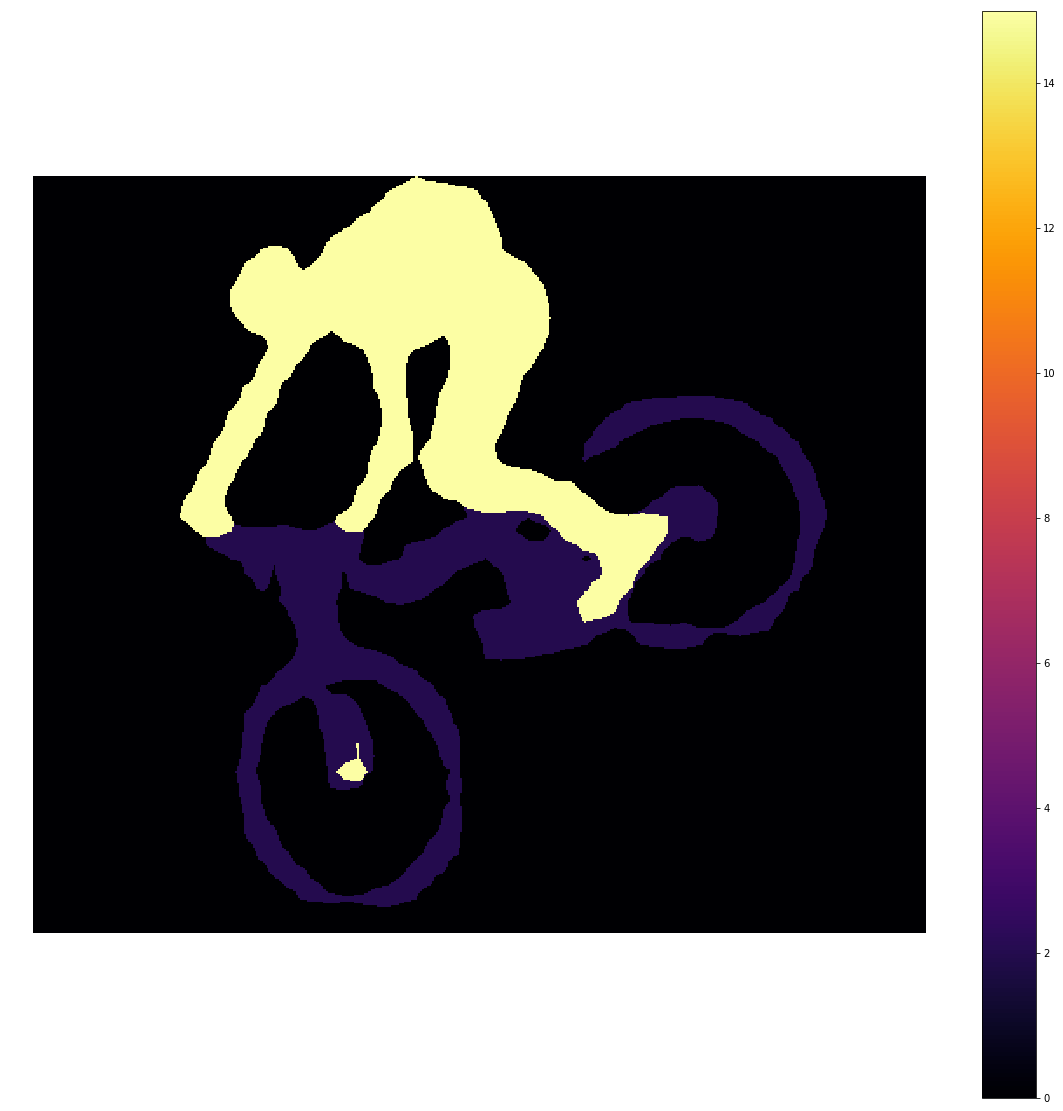

In [28]:
% matplotlib inline
import os
os.chdir('keras-deeplab-v3-plus-master') # go to keras-deeplab-v3-plusmaster
from matplotlib import pyplot as pylab
import cv2 # used for resize
import numpy as np
from model import Deeplabv3
deeplab_model = Deeplabv3()
pathIn = 'input' # path for the input image
pathOut = 'output' # output path for the segmented image
img = pylab.imread(pathIn + "/cycle.jpg")
w, h, _ = img.shape
ratio = 512. / np.max([w,h])
resized = cv2.resize(img,(int(ratio*h),int(ratio*w)))
resized = resized / 127.5 - 1.
pad_x = int(512 - resized.shape[0])
resized2 = np.pad(resized,((0,pad_x),(0,0),(0,0)),mode='constant')
res = deeplab_model.predict(np.expand_dims(resized2,0))
labels = np.argmax(res.squeeze(),-1)
pylab.figure(figsize=(20,20))
pylab.imshow(labels[:-pad_x], cmap='inferno'), pylab.axis('off'),
pylab.colorbar()
pylab.show()
pylab.savefig(pathOut + "\\segmented.jpg", bbox_inches='tight',
pad_inches=0)
pylab.close()
os.chdir('..')

# Transfer Learning with Keras

* First download the TensorFlow sample image dataset, available at http://download.tensorflow.org/example_images/flower_photos.tgz and unzip.
* Select 500 roses, sunflowers and tulip images each and put them in the **train** folder
* Select 50 roses, sunflowers and tulip images each and put them in the **valid** folder

In [1]:
from keras.applications import VGG16 
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.layers.normalization import BatchNormalization
import matplotlib.pylab as plt
from keras.preprocessing.image import load_img

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3)) # it will download weights for the first time

Using TensorFlow backend.


In [3]:
import numpy as np

train_dir = './flower_photos/train'
validation_dir = './flower_photos/valid'
 
nTrain = 500*3
nVal = 50*3


datagen = ImageDataGenerator(rescale=1./255)
batch_size = 25
 
train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,3))

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 1650 images belonging to 3 classes.


In [ ]:
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    #print(i * batch_size)
    if i * batch_size >= nTrain:
        break
         
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

In [5]:
validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,3))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)
i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break
         
validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512))

Found 150 images belonging to 3 classes.


In [6]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
#model.add(layers.Dense(256, activation='relu')) # make the neural network deep
#model.add(BatchNormalization())
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [7]:
model.compile(optimizer = optimizers.Adam(lr=1e-4), #optimizers.RMSprop(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['acc'])
 
history = model.fit(train_features,
                    train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    validation_data=(validation_features,validation_labels))

Train on 1500 samples, validate on 150 samples
Epoch 1/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.7524 - acc: 0.7473 - val_loss: 0.4640 - val_acc: 0.8533
Epoch 2/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2686 - acc: 0.8973 - val_loss: 0.3131 - val_acc: 0.8933
Epoch 3/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1422 - acc: 0.9493 - val_loss: 0.3989 - val_acc: 0.8533
Epoch 4/10
1500/1500 [==============================] - 11s 8ms/step - loss: 0.0985 - acc: 0.9620 - val_loss: 0.3599 - val_acc: 0.9000
Epoch 5/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0767 - acc: 0.9733 - val_loss: 0.2908 - val_acc: 0.9200
Epoch 6/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0552 - acc: 0.9813 - val_loss: 0.3111 - val_acc: 0.8933
Epoch 7/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0401 - acc: 0.9913 - val_loss: 0.3951 - val_acc: 0.8533
Epoch 8/

In [8]:
fnames = validation_generator.filenames 
ground_truth = validation_generator.classes 
label2index = validation_generator.class_indices 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items()) 
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features) 
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 18/150


In [9]:
label2index

{'roses': 0, 'sunflowers': 1, 'tulips': 2}

In [10]:
len(train_features), len(validation_features)

(1500, 150)

In [11]:
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 18/150


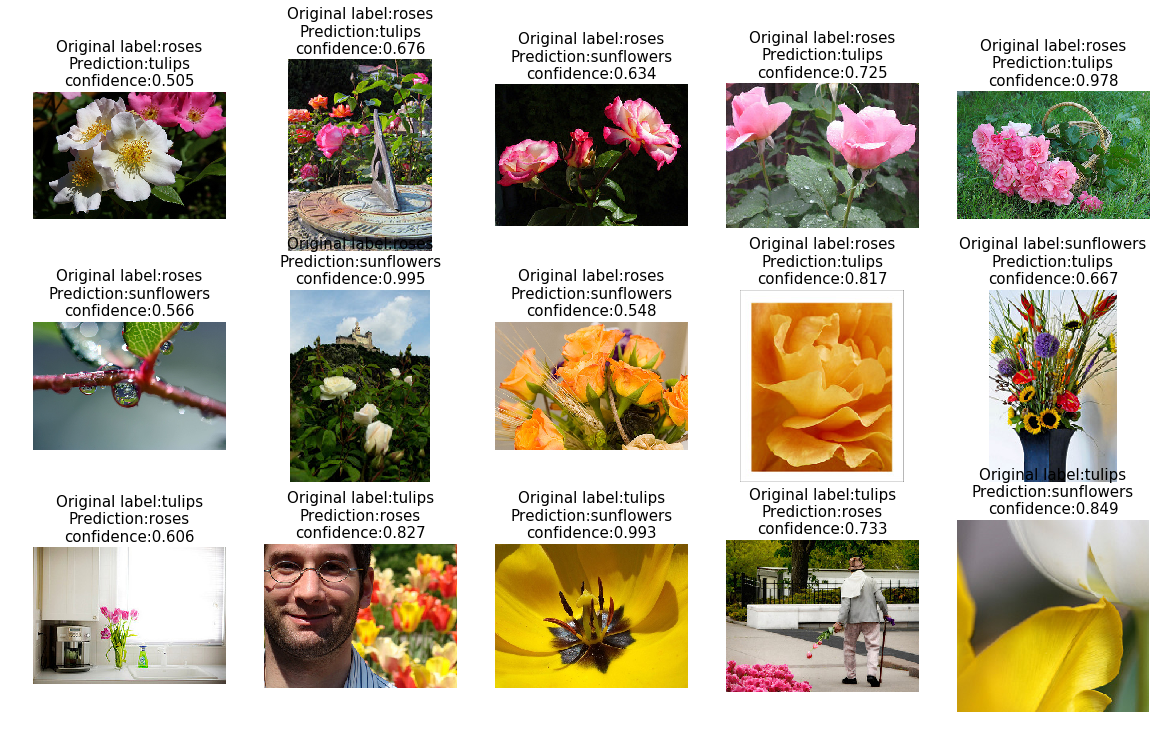

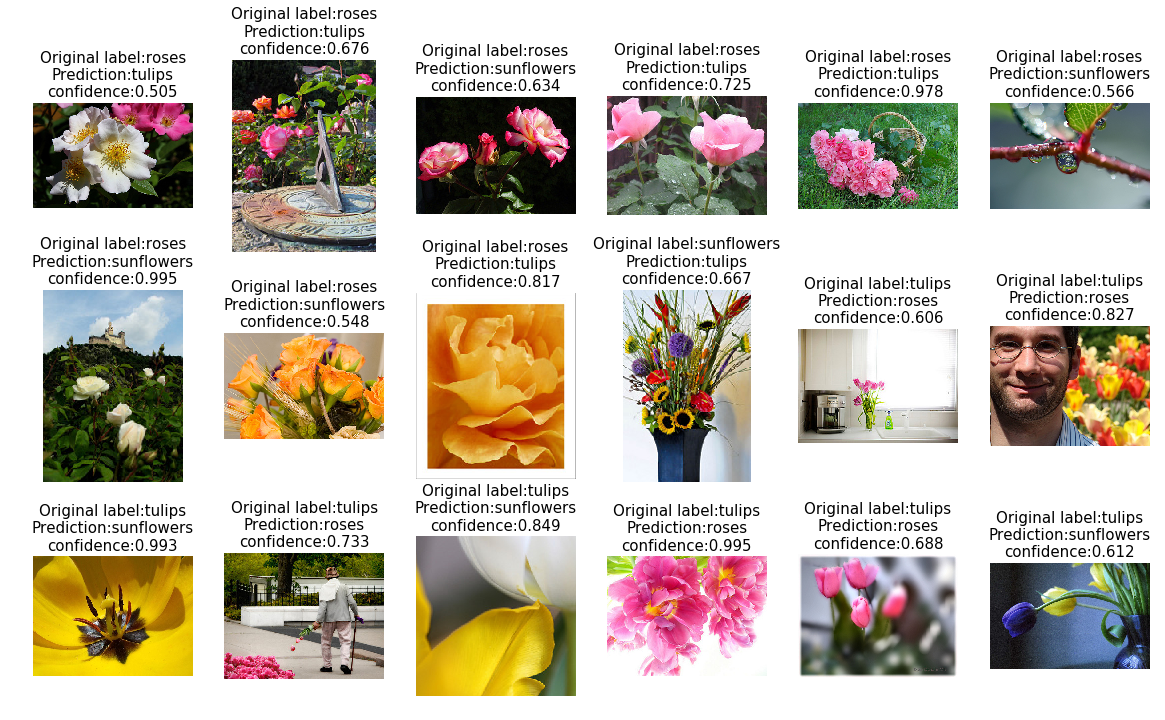

In [13]:
#errors = np.random.choice(errors, 5)
plt.figure(figsize=(20,12))
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.subplot(3,6,i+1), plt.imshow(original), plt.axis('off')
    plt.title('Original label:{}\nPrediction:{}\nconfidence:{:.3f}'.format(
        fnames[errors[i]].split('\\')[0],
        pred_label,
        prob[errors[i]][pred_class]), size=15)
plt.show()

## Object Detection using YOLO v2 with Keras

C:\Users\Sandipan.Dey\Anaconda\envs\ana41py35\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

Found 5 boxes for giraffe_zebra.jpg
zebra 0.83 (16, 325) (126, 477)
giraffe 0.89 (56, 175) (272, 457)
zebra 0.91 (370, 326) (583, 472)
giraffe 0.94 (388, 119) (554, 415)
giraffe 0.95 (205, 111) (388, 463)


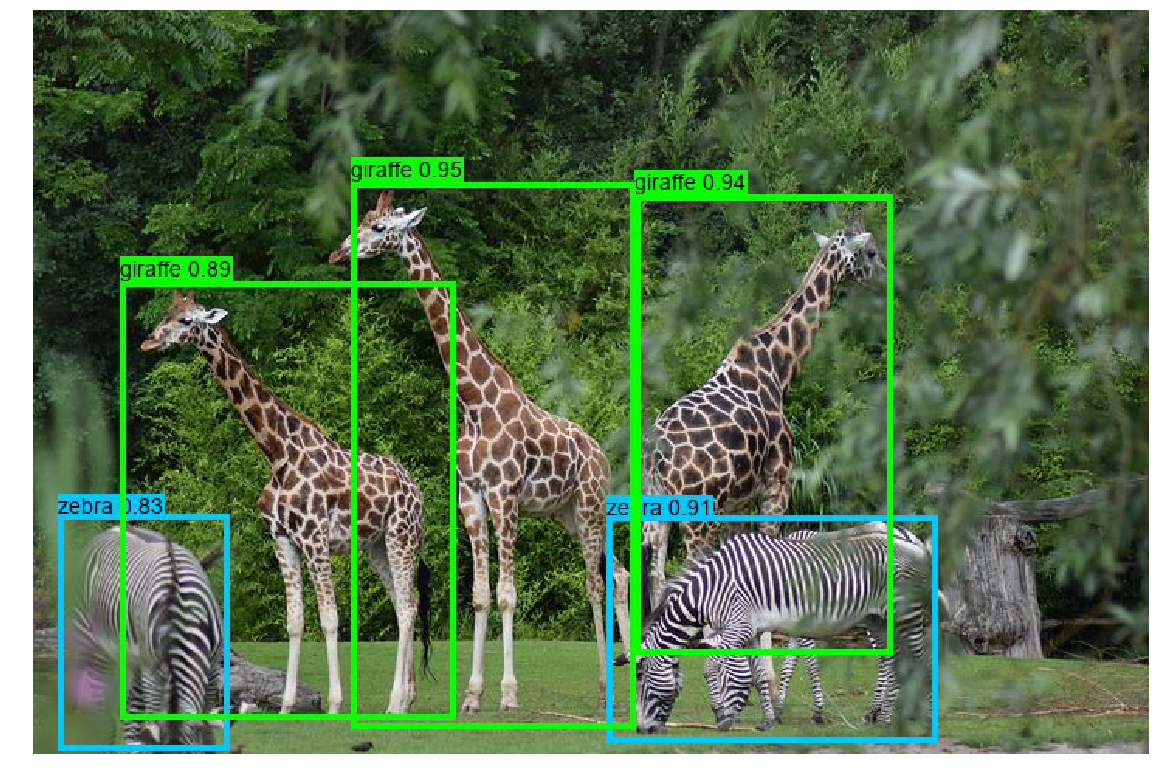

In [25]:
# import the needed modules
import os
import matplotlib.pylab as pylab
import scipy.io
import scipy.misc
import numpy as np
from PIL import Image
from keras import backend as K
from keras.models import load_model
# The following functions from the yad2k library will be used
# Note: it assumed that you have the yad2k folder in your current path,otherwise it will not work!
from yad2k.models.keras_yolo import yolo_head, yolo_eval
import colorsys
import imghdr
import random
from PIL import Image, ImageDraw, ImageFont


def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in
    range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101) # Fixed seed for consistent colors across runs.
    random.shuffle(colors) # Shuffle colors to decorrelate adjacent classes.
    random.seed(None) # Reset seed to default.
    return colors

def scale_boxes(boxes, image_shape):
    """ scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) # Add batch dimension.
    return image, image_data

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    font = ImageFont.truetype(font="arial.ttf", size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300
    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]
        label = '{} {:.2f}'.format(predicted_class, score)
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])
        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw
                              
# provide the name of the image that you saved in the images folder to be fed through the network
input_image_name = "giraffe_zebra.jpg"
input_image = Image.open("images/" + input_image_name)
width, height = input_image.size
width = np.array(width, dtype=float)
height = np.array(height, dtype=float)
image_shape = (height, width)
#Loading the classes and the anchor boxes that are copied to the yolo folder
class_names = read_classes("yolo/coco_classes.txt")    
anchors = read_anchors("yolo/yolo_anchors.txt")
#Load the pretrained model
# Download the weights and cfg file from https://pjreddie.com/darknet/yolo/ and create the yolo.h5 file with
# python yad2k.py yolov2.cfg yolov2.weights yolo/yolo.h5
yolo_model = load_model("yolo/yolo.h5")
#Print the summery of the model
yolo_model.summary()
# convert final layer features to bounding box parameters
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
#Now yolo_eval function selects the best boxes using filtering and non-max suppression techniques.
# If you want to dive in more to see how this works, refer keras_yolo.py file in yad2k/models
boxes, scores, classes = yolo_eval(yolo_outputs, image_shape)
# Initiate a session
sess = K.get_session()
#Preprocess the input image before feeding into the convolutional network
image, image_data = preprocess_image("images/" + input_image_name, model_image_size = (608, 608))
#Run the session
out_scores, out_boxes, out_classes = sess.run([scores, boxes,
classes],feed_dict={yolo_model.input:image_data,K.learning_phase(): 0})
#Print the results
print('Found {} boxes for {}'.format(len(out_boxes), input_image_name))
#Produce the colors for the bounding boxs
colors = generate_colors(class_names)
#Draw the bounding boxes   
draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
#Apply the predicted bounding boxes to the image and save it
image.save(os.path.join("output", input_image_name), quality=90)
output_image = scipy.misc.imread(os.path.join("output", input_image_name))
pylab.figure(figsize=(20,20))
pylab.imshow(output_image)
pylab.axis('off')
pylab.show()

## Style Transfer with torch pre-trained model / python-OpenCV

In [35]:
import cv2
import matplotlib.pyplot as pylab
import imutils
import time
model = 'neural-style-transfer/models/starry_night.t7' # assumes the pre-trained torch file is in this path, 
# download it from here: https://github.com/DmitryUlyanov/online-neural-doodle/blob/master/pretrained/starry_night.t7
print("loading style transfer model...")
net = cv2.dnn.readNetFromTorch(model)
image = cv2.imread('../images/monalisa.jpg') # the content image path
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
b, g, r = np.mean(image[...,0]), np.mean(image[...,1]), np.mean(image[...,2])
# construct a blob from the image, set the input, and then perform a
# forward pass of the network
blob = cv2.dnn.blobFromImage(image, 1.0, (w, h), (b, g, r), swapRB=False, crop=False)
net.setInput(blob)
start = time.time()
output = net.forward()
end = time.time()
# reshape the output tensor, add back in the mean subtraction, and
# then swap the channel ordering
output = output.reshape((3, output.shape[2], output.shape[3]))
output[0] += b
output[1] += g
output[2] += r
#output /= 255.0
output = output.transpose(1, 2, 0)
# show information on how long inference took
print("neural style transfer took {:.4f} seconds".format(end - start))
# show the images
print(output.shape)
cv2.imwrite('output/styled.jpg', output)

loading style transfer model...
neural style transfer took 0.9367 seconds
(896, 600, 3)


True